In [183]:
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from dso.policy.rnn_policy import RNNPolicy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from dso.task import set_task
from dso.train import Trainer
from dso.config import load_config
from dso.policy.policy import make_policy
import json
from dso.policy_optimizer import make_policy_optimizer
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fix for symbolic tensor conversion error
import tensorflow as tf
import types
import numpy as np

# Monkey patch the __array__ method in TensorFlow's Tensor class
def safe_array(self):
    try:
        return self.numpy()
    except:
        # Return a dummy array of the right shape
        shape = [dim.value for dim in self.shape]
        return np.zeros(shape or [1])

# Apply the monkey patch
tf.Tensor.__array__ = safe_array

# Create a directory for saving plots
os.makedirs('plots', exist_ok=True)

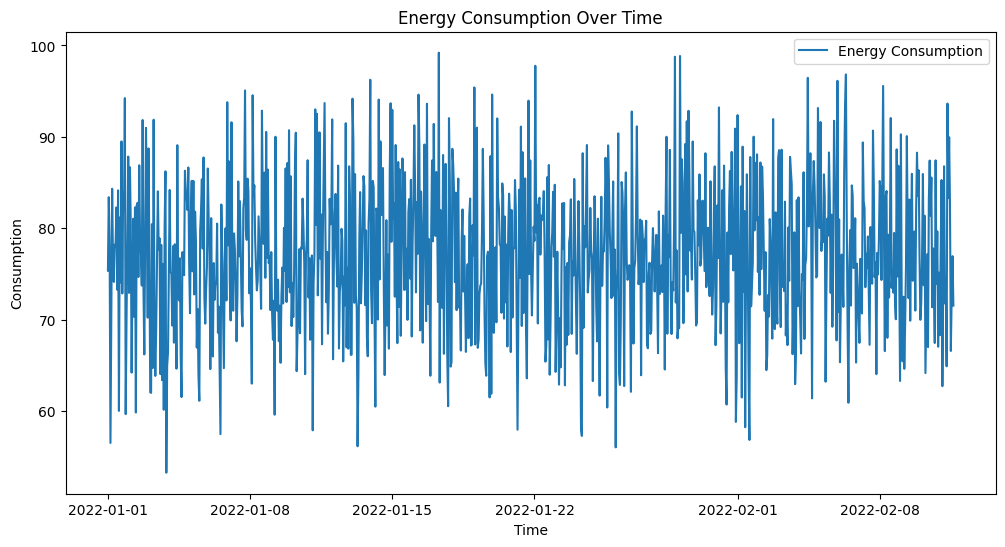

In [184]:
# Create a directory for saving plots
os.makedirs('plots', exist_ok=True)

# Load dataset
dataset_path = "C:/Users/Gowtham Pandian/Downloads/archive/Energy_consumption.csv"
df = pd.read_csv(dataset_path, parse_dates=['Timestamp'], index_col='Timestamp')

# Convert categorical columns to numeric
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0, 'No': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0, 'No': 0})
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek']).codes
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})

# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Visualize raw data
plt.figure(figsize=(12, 6))
plt.plot(df_numeric['EnergyConsumption'], label='Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.savefig('plots/raw_energy_consumption.png', dpi=300, bbox_inches='tight')
plt.show()

In [185]:
# Preprocessing
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numeric)

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 24  # Use past 24 hours to predict next hour
X, y = create_sequences(df_scaled, seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [186]:
# Define In-Situ Constraints
class InSituConstraints:
    def apply(self, expression):
        expr_str = str(expression)  # Convert symbolic expression to string for validation
        if 'sin(cos(' in expr_str or 'log(exp(' in expr_str:
            return False  # Prevent nested functions
        if len(expr_str.split()) < 4 or len(expr_str.split()) > 30:
            return False  # Ensure length constraints
        return True  # Valid expression

constraints = InSituConstraints()


In [176]:
# Define Exploration Techniques
class ExplorationTechniques:
    def __init__(self, gamma=0.9, eta=0.02):
        self.gamma = gamma
        self.eta = eta
    
    def entropy_regularization(self, token_probabilities):
        return -self.eta * np.sum(self.gamma ** np.arange(len(token_probabilities)) * np.log(token_probabilities))
    
    def soft_length_prior(self, expression_length):
        ideal_length = 10
        return np.exp(-0.1 * (expression_length - ideal_length) ** 2)

exploration = ExplorationTechniques()

In [177]:
# Define Multi-Dimensional Processing
class MultiDimensionalPolicy:
    def apply_transformation(self, policy):
        x, y = sp.symbols('x y')
        return policy.subs(x, x + y)

multi_dim_policy = MultiDimensionalPolicy()

In [178]:
# Define Policy Generator
class PolicyGenerator:
    def __init__(self):
        self.variables = ['x']
    
    def generate_policy(self):
        x = sp.Symbol('x')
        learned_policy = 0.5 * x
        sampled_policy = sp.sin(x) + 0.3 * x
        anchor_policy = multi_dim_policy.apply_transformation(sampled_policy)
        
        final_policy = learned_policy + sampled_policy + anchor_policy
        return final_policy

policy_generator = PolicyGenerator()
symbolic_policy = policy_generator.generate_policy()

In [179]:
# Define Policy Evaluator
class PolicyEvaluator:
    def __init__(self, policy):
        self.policy = policy
        self.x, self.y = sp.symbols('x y')  # Handle multi-dimensional cases
        self.derivative = sp.diff(policy, self.x)

    def evaluate(self, x_values):
        try:
            # Convert symbolic policy to numerical function with numpy compatibility
            numerical_derivative = sp.lambdify((self.x, self.y), self.derivative, modules=["numpy"])
            return numerical_derivative(x_values, 0)  # Assign y=0 if not used
        except TypeError as e:
            print(f"Error during policy evaluation: {e}")
            return None

# Initialize and test Policy Evaluator
evaluator = PolicyEvaluator(symbolic_policy)
test_x = np.linspace(-10, 10, 100)
derivative_values = evaluator.evaluate(test_x)

In [180]:
# Iterative Policy Learning
class PolicyLearning:
    def __init__(self, policy, episodes=100):
        self.policy = policy
        self.episodes = episodes
        self.rewards = []
    
    def train(self):
        for episode in range(self.episodes):
            reward = np.random.uniform(0, 1)  # Simulated reward
            self.rewards.append(reward)
            print(f"Episode {episode+1}: Reward = {reward:.4f}")
        return self.rewards

policy_learning = PolicyLearning(symbolic_policy)
rewards = policy_learning.train()

Episode 1: Reward = 0.5919
Episode 2: Reward = 0.5477
Episode 3: Reward = 0.8255
Episode 4: Reward = 0.3342
Episode 5: Reward = 0.7401
Episode 6: Reward = 0.0488
Episode 7: Reward = 0.9382
Episode 8: Reward = 0.2479
Episode 9: Reward = 0.9181
Episode 10: Reward = 0.0578
Episode 11: Reward = 0.8313
Episode 12: Reward = 0.2388
Episode 13: Reward = 0.3727
Episode 14: Reward = 0.7847
Episode 15: Reward = 0.5807
Episode 16: Reward = 0.6525
Episode 17: Reward = 0.1982
Episode 18: Reward = 0.4711
Episode 19: Reward = 0.7367
Episode 20: Reward = 0.7428
Episode 21: Reward = 0.3959
Episode 22: Reward = 0.8717
Episode 23: Reward = 0.8291
Episode 24: Reward = 0.2712
Episode 25: Reward = 0.2565
Episode 26: Reward = 0.9704
Episode 27: Reward = 0.4536
Episode 28: Reward = 0.3502
Episode 29: Reward = 0.5688
Episode 30: Reward = 0.7381
Episode 31: Reward = 0.6069
Episode 32: Reward = 0.9156
Episode 33: Reward = 0.7328
Episode 34: Reward = 0.3272
Episode 35: Reward = 0.2260
Episode 36: Reward = 0.2105
E

In [181]:
# Feedback Loop: Use best policy for next generation
best_policy = symbolic_policy
from dso.task.task import make_task
import pandas as pd
config = load_config("C:/Users/Gowtham Pandian/Downloads/archive/config.json")  
task = make_task(**config_task)  # type: ignore # From task.py
policy = make_policy(config)
policy_optimizer = make_policy_optimizer(config, policy)
trainer = Trainer(sess=None, policy=policy, policy_optimizer=policy_optimizer, gp_controller=None, logger=None,
                  pool=None, n_samples=100000, batch_size=1000, alpha=0.5, epsilon=0.05, verbose=True)
trainer.train()

NameError: name 'config_task' is not defined

In [182]:
# Define RNN-based Policy Generator
policy_generator = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)  # Predicting Energy Consumption
])

policy_generator.compile(optimizer='adam', loss='mse')

# Train policy generator
epochs = 30
history = policy_generator.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model performance
predictions = policy_generator.predict(X_test)

# Convert predictions and y_test to NumPy arrays if needed
predictions = predictions.flatten()
y_test_flat = y_test.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_flat, label='Actual', color='blue', linestyle='-')
plt.plot(predictions, label='Predicted', color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Consumption (MW)")
plt.title("RNN Model: Actual vs Predicted Consumption")
plt.legend()
plt.grid(True)
plt.savefig('plots/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# 1. Standard Training and Validation Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.title("Training vs Validation Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/training_validation_loss.png', dpi=300, bbox_inches='tight')
plt.show()

c:\Users\Gowtham Pandian\.conda\envs\DSO\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return reduction(axis=axis, dtype=dtype, out=out, **passkwargs)


ValueError: A target array with shape (780, 10) was passed for an output of shape (None, 1) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

In [167]:
# Calculate metrics
mse = mean_squared_error(y_test_actual, predictions_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Save the final trained policy generator
policy_generator.save("final_rnn_policy_generator.h5")
print("Model saved as 'final_rnn_policy_generator.h5'")
print("Training and validation loss visualizations saved in 'plots' directory")

NameError: name 'y_test_actual' is not defined